# CSE 519: Data Science

## Kaggle Google Analytics Customer Revenue Prediction
---
Name: Sagar Gurtu<br>

### Task 1

1. Import all the required libraries.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import lightgbm as lgbm
import math
import json
import re
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.cluster import AgglomerativeClustering

2. There are JSON columns in the training as well as test data. While reading the CSV, they are read as json object columns. Also 'fullVisitorId', 'visitId' and 'sessionId' have been loaded as string type and 'visitStartTime' and 'date' have been parsed as dates.

In [2]:
json_columns = ['device', 'geoNetwork', 'totals', 'trafficSource']

def load_csv(csv):
    return pd.read_csv(csv, 
                 dtype = {'fullVisitorId': str, 'sessionId':str, 'visitId': str},
                 converters = {column: json.loads for column in json_columns},
                 parse_dates = ['visitStartTime', 'date'],
                 encoding = 'utf8')

In [3]:
df = load_csv('train.csv')

In [4]:
test = load_csv('test.csv')

3. Let's look at the data 

In [5]:
df.head()

,channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,2016-09-02,{u'mobileDeviceBranding': u'not available in d...,1131660440785968503,"{u'city': u'Izmir', u'networkDomain': u'ttnet....",1131660440785968503_1472830385,Not Socially Engaged,"{u'bounces': u'1', u'hits': u'1', u'pageviews'...",{u'adwordsClickInfo': {u'criteriaParameters': ...,1472830385,1,1472830385
1,Organic Search,2016-09-02,{u'mobileDeviceBranding': u'not available in d...,377306020877927890,"{u'city': u'not available in demo dataset', u'...",377306020877927890_1472880147,Not Socially Engaged,"{u'bounces': u'1', u'hits': u'1', u'pageviews'...",{u'adwordsClickInfo': {u'criteriaParameters': ...,1472880147,1,1472880147
2,Organic Search,2016-09-02,{u'mobileDeviceBranding': u'not available in d...,3895546263509774583,"{u'city': u'Madrid', u'networkDomain': u'unkno...",3895546263509774583_1472865386,Not Socially Engaged,"{u'bounces': u'1', u'hits': u'1', u'pageviews'...",{u'adwordsClickInfo': {u'criteriaParameters': ...,1472865386,1,1472865386
3,Organic Search,2016-09-02,{u'mobileDeviceBranding': u'not available in d...,4763447161404445595,"{u'city': u'not available in demo dataset', u'...",4763447161404445595_1472881213,Not Socially Engaged,"{u'bounces': u'1', u'hits': u'1', u'pageviews'...",{u'adwordsClickInfo': {u'criteriaParameters': ...,1472881213,1,1472881213
4,Organic Search,2016-09-02,{u'mobileDeviceBranding': u'not available in d...,27294437909732085,"{u'city': u'not available in demo dataset', u'...",27294437909732085_1472822600,Not Socially Engaged,"{u'bounces': u'1', u'hits': u'1', u'pageviews'...","{u'medium': u'organic', u'campaign': u'(not se...",1472822600,2,1472822600


4. And their data types,

In [6]:
df.dtypes

channelGrouping                 object
date                    datetime64[ns]
device                          object
fullVisitorId                   object
geoNetwork                      object
sessionId                       object
socialEngagementType            object
totals                          object
trafficSource                   object
visitId                         object
visitNumber                      int64
visitStartTime                  object
dtype: object

5. Now, we'll split 'visitStartTime' column into week, day, hour columns and 'date' column into year and month columns.

In [7]:
def split_date(df):
    df['visitStartTime'] = pd.to_datetime(df['visitStartTime'], unit = 's')
    df['visitStartTime.week'] = df['visitStartTime'].dt.dayofweek
    df['visitStartTime.day'] = df['visitStartTime'].dt.hour
    df['visitStartTime.hour'] = df['visitStartTime'].dt.day
    df['date.year'] = df['date'].dt.year
    df['date.month'] = df['date'].dt.month

In [8]:
split_date(df)

In [9]:
split_date(test)

6. For each JSON column ('device', 'geoNetwork', 'totals', 'trafficSource'), we'll split it into individual columns with respective 'key' as the headers and 'value' as their values.

In [10]:
def split_json_columns(df):
    for column in json_columns:
        df = df.join(pd.io.json.json_normalize(df[column]).add_prefix(column + '.'))
        df.drop([column], axis = 1, inplace = True)
    return df

In [11]:
df = split_json_columns(df)

In [12]:
test = split_json_columns(test)

7. We'll check for columns having NA as their values.

In [13]:
df.isna().sum()

channelGrouping                                           0
date                                                      0
fullVisitorId                                             0
sessionId                                                 0
socialEngagementType                                      0
visitId                                                   0
visitNumber                                               0
visitStartTime                                            0
visitStartTime.week                                       0
visitStartTime.day                                        0
visitStartTime.hour                                       0
date.year                                                 0
date.month                                                0
device.browser                                            0
device.browserSize                                        0
device.browserVersion                                     0
device.deviceCategory                   

8. Now, we'll collect those columns which have all their values as null or 'not available in demo dataset'.

In [14]:
null_count = ((df[df.columns] == 'not available in demo dataset') | (df[df.columns].isna())).sum()

In [15]:
null_col = [col for col in null_count.keys() if null_count[str(col)] > 0 if null_count[str(col)] == len(df) ]
null_col

['device.browserSize',
 'device.browserVersion',
 'device.flashVersion',
 'device.language',
 'device.mobileDeviceBranding',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.operatingSystemVersion',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'trafficSource.adwordsClickInfo.criteriaParameters']

Dropping these columns since these are irrelevant.

In [16]:
df.drop(columns = null_col, inplace = True)

9. We need to assign something to those columns which have only a small fraction of values as null. So, we'll fill:<br>
a) 0 in transactionRevenue column wherever it is null. Ofcourse, if transaction revenue is not present, it means no revenue has been generated and we can safely assign 0.<br>
b) 0 in newVisits and bounces columns wherever they are null. Reason similar to above.<br>
d) empty string in referral path column instead of null.<br>
e) '(not provided)' in keyword column wherever it is null because this value is already present in the column in place of NA.<br>
f) False in isTrueDirect column wherever it is null. We'll consider absence of boolean value as False here instead of null.

There are only 100 rows with pageviews as null. Dropping those rows.

In [17]:
df['totals.transactionRevenue'].fillna(0, inplace = True)

In [18]:
df['totals.newVisits'].fillna(0, inplace = True)

In [20]:
df = df[pd.notnull(df['totals.pageviews'])]

In [21]:
df['totals.bounces'].fillna(0, inplace = True)

In [22]:
df['trafficSource.referralPath'].fillna('', inplace = True)

In [23]:
df['trafficSource.keyword'].fillna('(not provided)', inplace = True)

In [24]:
df['trafficSource.isTrueDirect'].fillna(False, inplace = True)

10. We'll drop all those columns which have 80% or more of their values as null since they won't be useful for prediction.

In [25]:
null_count = ((df[df.columns] == 'not available in demo dataset') | (df[df.columns].isna())).sum()

In [26]:
null_col = [col for col in null_count.keys() if null_count[str(col)] > 0 if null_count[str(col)] == len(df) ]

In [27]:
cols_to_discard = [col for col in null_count.keys() if null_count[str(col)] > 0 
                   if (float(null_count[str(col)])/len(df) * 100) > 80]

Below are the said columns to be discarded.

In [28]:
cols_to_discard

['trafficSource.adContent',
 'trafficSource.adwordsClickInfo.adNetworkType',
 'trafficSource.adwordsClickInfo.gclId',
 'trafficSource.adwordsClickInfo.isVideoAd',
 'trafficSource.adwordsClickInfo.page',
 'trafficSource.adwordsClickInfo.slot',
 'trafficSource.campaignCode']

In [29]:
df.drop(columns=cols_to_discard, inplace = True)

11. We'll find those columns which have all their values equal. These will have no impact on prediction and can be dropped.

In [30]:
all_same_col = [col for col in df.columns if df[col].nunique() == 1 ]

In [31]:
all_same_col

[u'socialEngagementType', 'totals.visits']

In [32]:
df.drop(columns = all_same_col, inplace = True)

12. Converting the necessary columns to numeric data type,

In [33]:
df['totals.transactionRevenue'] = df['totals.transactionRevenue'].apply(pd.to_numeric)
df['totals.bounces'] = df['totals.bounces'].apply(pd.to_numeric)
df['totals.hits'] = df['totals.hits'].apply(pd.to_numeric)
df['totals.newVisits'] = df['totals.newVisits'].apply(pd.to_numeric)
df['totals.pageviews'] = df['totals.pageviews'].apply(pd.to_numeric)

13. Saving cleaned data to disk

In [34]:
df.to_csv('cleaned_train.csv', encoding='utf8')

In [35]:
test.to_csv('cleaned_test.csv', encoding='utf8')

<hr>

### Task 2

1. Let's look at the correlation

In [36]:
corr = df.corr()
corr

,visitNumber,visitStartTime.week,visitStartTime.day,visitStartTime.hour,date.year,date.month,device.isMobile,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.isTrueDirect
visitNumber,1.000000,-0.019323,0.024887,-0.002602,0.007857,-0.011256,-0.037660,-0.023721,0.041339,-0.255088,0.043363,0.051377,0.181684
visitStartTime.week,-0.019323,1.000000,-0.040152,-0.021127,-0.005063,0.010137,0.082114,0.018823,-0.010822,0.038630,-0.011552,-0.007332,-0.040936
visitStartTime.day,0.024887,-0.040152,1.000000,-0.002699,0.020379,-0.024723,-0.025011,-0.030905,0.017321,-0.043812,0.018783,0.011052,0.042654
visitStartTime.hour,-0.002602,-0.021127,-0.002699,1.000000,-0.001955,-0.015529,0.002636,0.001628,-0.004040,0.003085,-0.003831,0.000254,0.008501
date.year,0.007857,-0.005063,0.020379,-0.001955,1.000000,-0.868277,0.144879,0.002653,-0.017502,-0.043661,-0.011249,0.003195,0.083302
date.month,-0.011256,0.010137,-0.024723,-0.015529,-0.868277,1.000000,-0.107000,-0.004660,0.003126,0.034415,-0.002308,-0.002848,-0.071654
device.isMobile,-0.037660,0.082114,-0.025011,0.002636,0.144879,-0.107000,1.000000,0.021365,-0.030377,0.021596,-0.030199,-0.016556,0.078754
totals.bounces,-0.023721,0.018823,-0.030905,0.001628,0.002653,-0.004660,0.021365,1.000000,-0.371193,0.078692,-0.404617,-0.032211,-0.044417
totals.hits,0.041339,-0.010822,0.017321,-0.004040,-0.017502,0.003126,-0.030377,-0.371193,1.000000,-0.115274,0.983205,0.154333,0.084014
totals.newVisits,-0.255088,0.038630,-0.043812,0.003085,-0.043661,0.034415,0.021596,0.078692,-0.115274,1.000000,-0.117263,-0.041176,-0.615957


2. Plotting a correlation heatmap, we get

Text(0.5,1,'Correlation Heatmap')

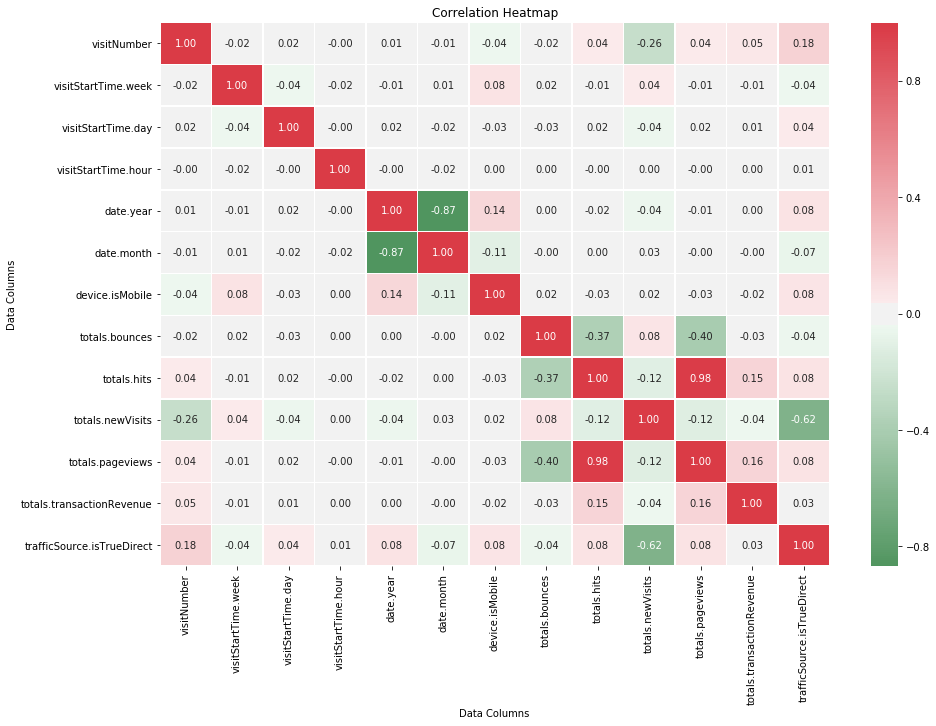

In [37]:
plt.subplots(figsize = (15,10))
ax = sns.heatmap(corr, 
            cmap = sns.diverging_palette(133, 10, as_cmap = True), 
            annot=True, 
            fmt='.2f', 
            center=0.00, 
            linewidths=.5)
ax.set(xlabel = 'Data Columns', ylabel = 'Data Columns')
ax.set_title('Correlation Heatmap')

It is observed that there is not much correlation between the data fields. There is a slight negative correlation between totals.newVisits and trafficSource.isTrueDirect, totals.bounces and totals.hits, date.month and date.year, the last of which is irrevelant to our problem.

3. Let's add a new column of the format (month, year) using the date column.

In [38]:
df['month.year'] = df.apply (lambda row: '(' + str(row['date.month']) + ', ' + str(row['date.year']) + ')', axis = 1)

4. We'll plot a heatmap by grouping the data based on (month, year) and device.operatingSystem and using values as the sum of totals.transactionRevenue.

Text(0.5,1,'Heatmap showing the Sum of Transaction Revenue per month per operating system user')

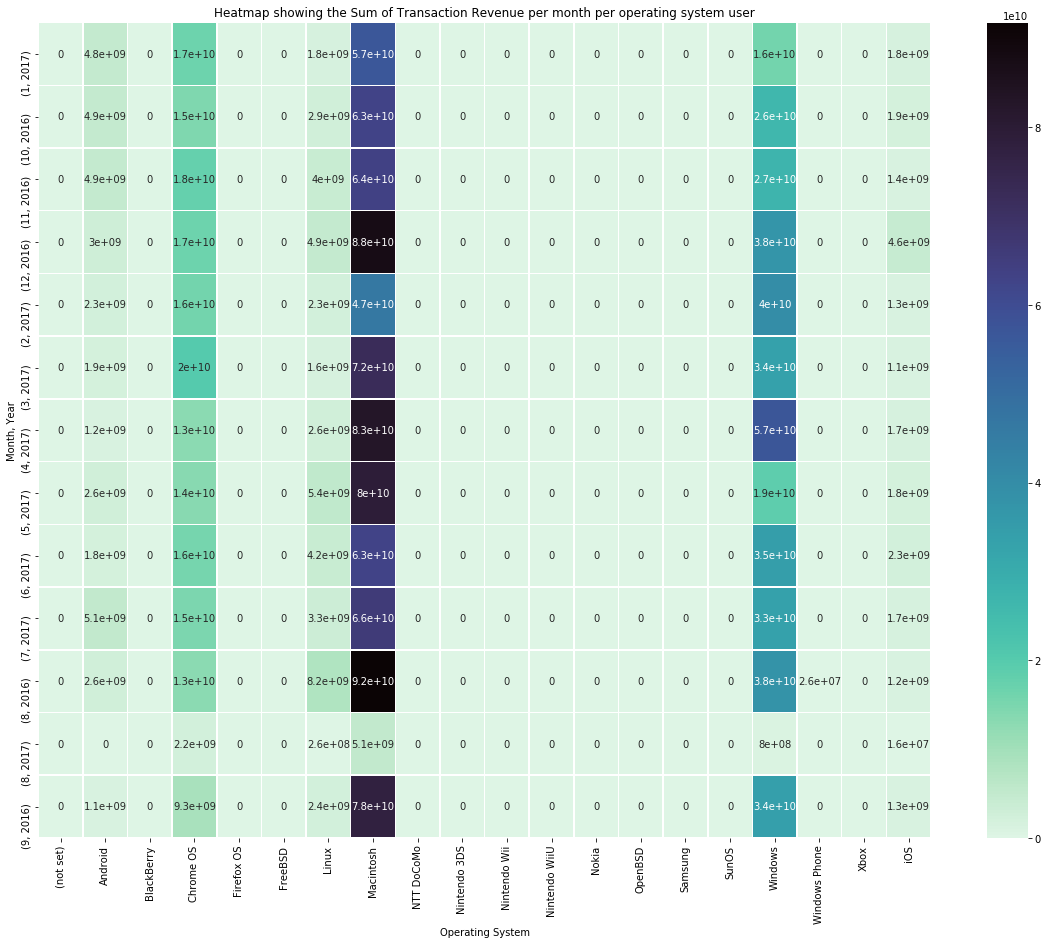

In [39]:
plt.subplots(figsize = (20,15))
temp_df = df.groupby(['month.year', 'device.operatingSystem']).sum().reset_index().pivot('month.year', 
                                                                                         'device.operatingSystem', 
                                                                                         'totals.transactionRevenue')
temp_df.fillna(0, inplace = True)
ax = sns.heatmap(temp_df, cmap = sns.cm.mako_r, annot = True, linewidths = .5)
ax.set(xlabel = 'Operating System', ylabel = 'Month, Year')
ax.set_title('Heatmap showing the Sum of Transaction Revenue per month per operating system user')

Here, we observe that the amount of revenue generated is maximum from Macintosh and Windows with Chrome OS, Linux, Android and iOS just behind. Also, a large amount of revenue was generated in August 2016, September 2016, November 2016, December 2016 and April 2017. In addition, there are a lot of operating systems through which no revenue was generated (e.g. Blackberry, Firefox OS). 

5. Again, we'll plot a heatmap by grouping the data based on (month, year) and device.operatingSystem and but this time using values as the count of totals.transactionRevenue.

Text(0.5,1,'Heatmap showing the Number of Visits per month per operating system user')

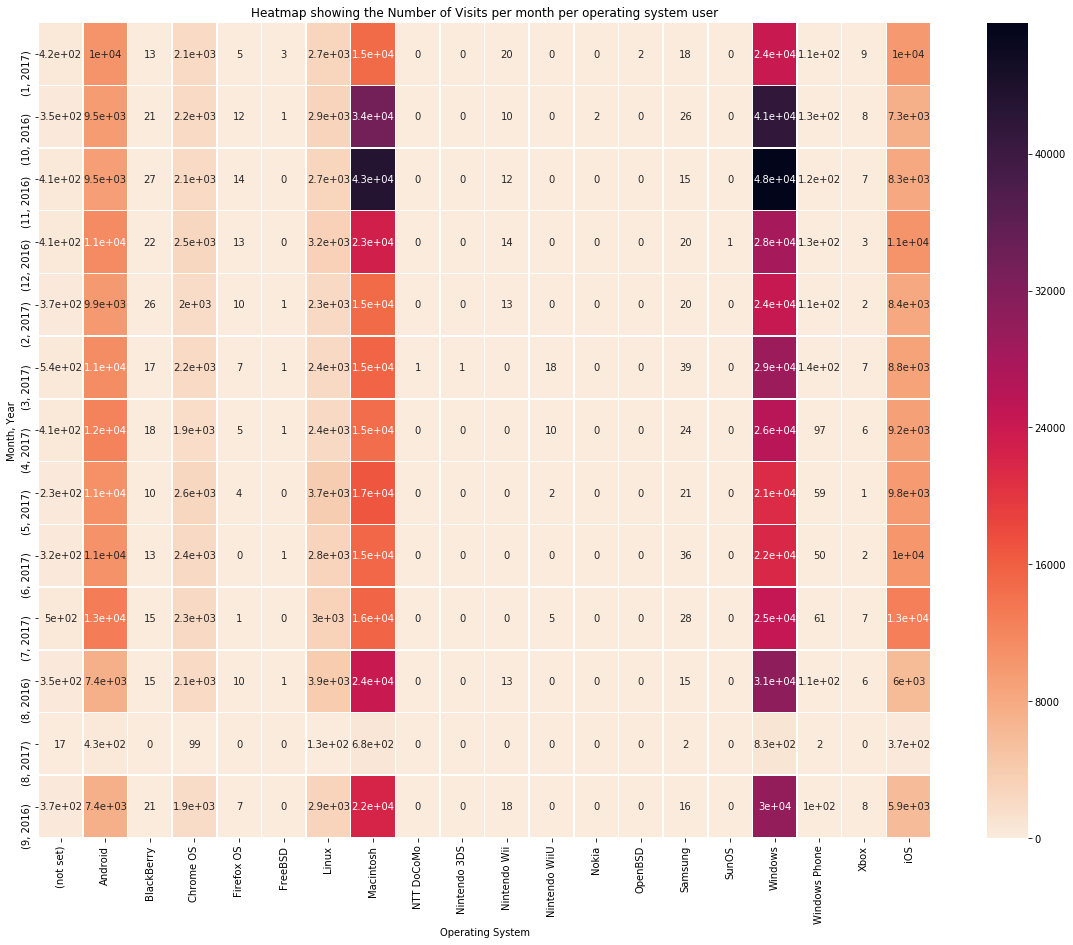

In [40]:
plt.subplots(figsize = (20,15))
temp_df = df.groupby(['month.year', 'device.operatingSystem']).count().reset_index().pivot('month.year', 
                                                                                       'device.operatingSystem', 
                                                                                       'totals.pageviews')
temp_df.fillna(0, inplace = True)
ax = sns.heatmap(temp_df, cmap = sns.cm.rocket_r, annot = True, linewidths = .5)
ax.set(xlabel = 'Operating System', ylabel = 'Month, Year')
ax.set_title('Heatmap showing the Number of Visits per month per operating system user')

Here, we observe that the number of visits is maximum from Macintosh and Windows with Android, iOS, Chrome OS and Linux just behind. This trend is similar to the heatmap with the amount of transaction revenues but here almost all operating systems have been used to visit the store if not bought from. Also, a large number of visits were done in August 2016, September 2016, October 2016, November 2016, December 2016 and April 2017, similar to the previous heatmap.

6. Plotting a count of device.operatingSystem,

Text(0.5,1,'Number of visits by different operating system users')

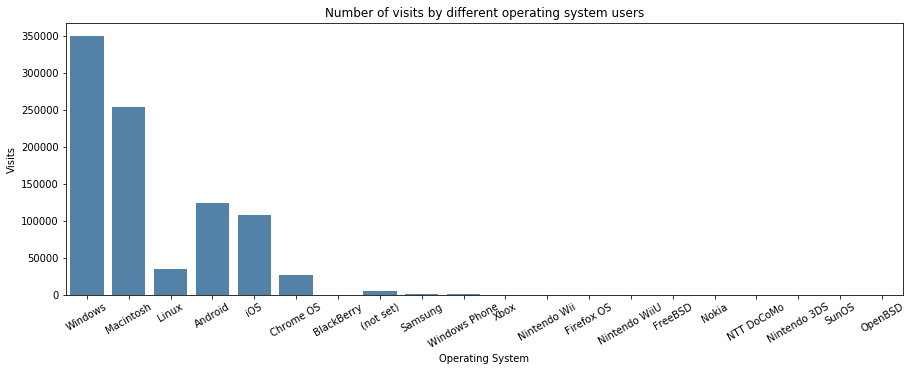

In [41]:
plt.subplots(figsize = (15,5))
ax = sns.countplot(data=df, x = 'device.operatingSystem', color="steelblue")
ax.set_xticklabels(plt.xticks()[1], rotation = 30)
ax.set(xlabel = 'Operating System', ylabel = 'Visits')
ax.set_title('Number of visits by different operating system users')

The above shows that store visits was maximum from Windows and Mac followed by Android and iOS.

7. Now, let's look at the revenue generated from the different operating systems,

Text(0.5,1,'Operating system users vs Transaction Revenue')

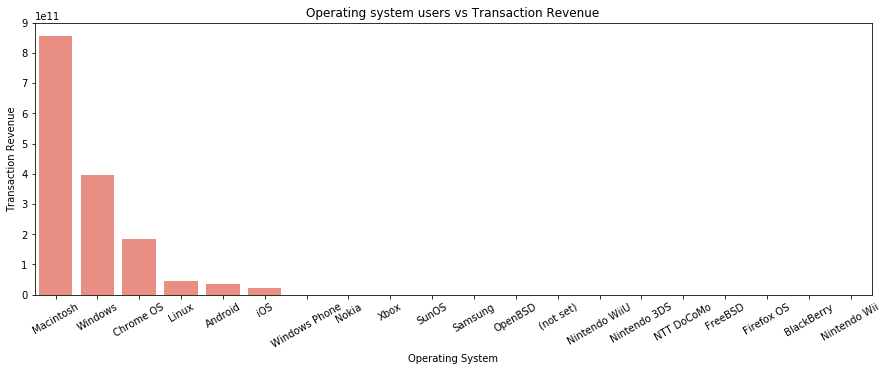

In [42]:
plt.subplots(figsize = (15,5))
ax = sns.barplot(data = df.groupby(['device.operatingSystem']).sum().reset_index().sort_values('totals.transactionRevenue', 
                                                                                               ascending = False), 
            x = 'device.operatingSystem', y = 'totals.transactionRevenue', color = 'salmon')
ax.set_xticklabels(plt.xticks()[1], rotation=30)
ax.set(xlabel = 'Operating System', ylabel = 'Transaction Revenue')
ax.set_title('Operating system users vs Transaction Revenue')

The above shows a different trend than store visits. Here, maximum transaction revenue is generated from Mac users and then Windows. But now the next in line is Chrome OS. Even though Android and iOS visitors were significant, revenue generated from these users are comparatively lesser.

8. We'll now look at the device.browser counts

Text(0.5,1,'Number of visits by different browsers')

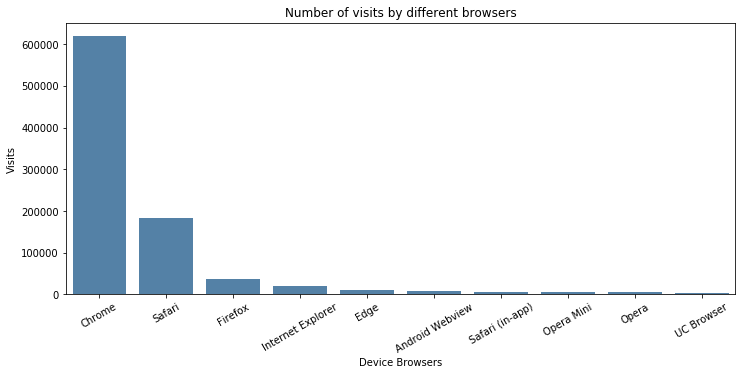

In [43]:
temp_df = df.groupby(['device.browser']).count().reset_index().sort_values('totals.pageviews', ascending = False).head(10)
plt.subplots(figsize = (12,5))
ax = sns.barplot(data = temp_df, x = 'device.browser', y = 'totals.pageviews', color = 'steelblue')
ax.set_xticklabels(plt.xticks()[1], rotation = 30)
ax.set(xlabel = 'Device Browsers', ylabel = 'Visits')
ax.set_title('Number of visits by different browsers')

Clearly, maximum visits have been made by Chrome and Safari users.

9. Plotting device.browser vs transactionRevenue,

Text(0.5,1,'Browsers vs Transaction Revenue')

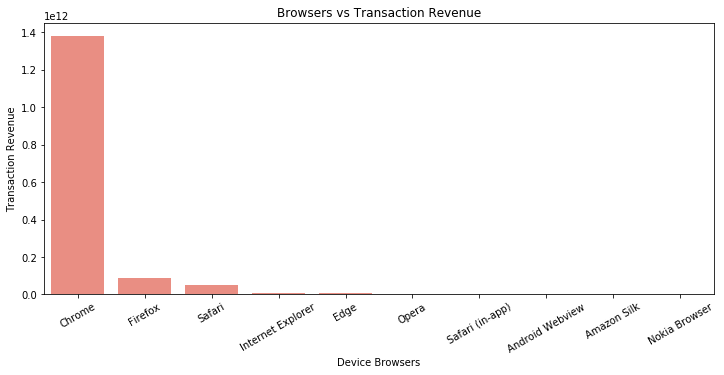

In [44]:
temp_df = df.groupby(['device.browser']).sum().reset_index().sort_values('totals.transactionRevenue', ascending = False).head(10)
plt.subplots(figsize = (12,5))
ax = sns.barplot(data = temp_df, x = 'device.browser', y = 'totals.transactionRevenue', color = 'salmon')
ax.set_xticklabels(plt.xticks()[1], rotation = 30)
ax.set(xlabel = 'Device Browsers', ylabel = 'Transaction Revenue')
ax.set_title('Browsers vs Transaction Revenue')

Most revenue has been generated by Chrome users.

10. Plotting count of different devices,

Text(0.5,1,'Number of visits by different devices')

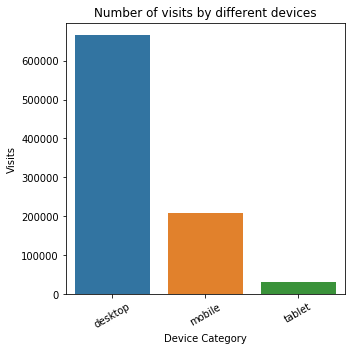

In [45]:
plt.subplots(figsize = (5,5))
ax = sns.countplot(data = df, x = 'device.deviceCategory')
ax.set_xticklabels(plt.xticks()[1], rotation = 30)
ax.set(xlabel = 'Device Category', ylabel = 'Visits')
ax.set_title('Number of visits by different devices')

Desktop users are top visitors of the store.

11. Similarly, on plotting deviceCategory vs transactionRevenue, it is observed that maximum revenue has been generated by desktop users.

Text(0.5,1,'Device Category vs Transaction Revenue')

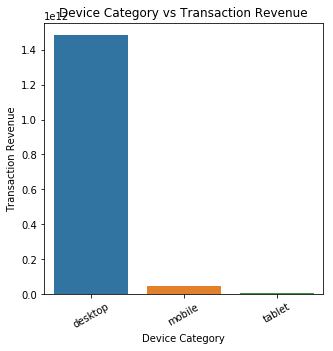

In [204]:
plt.subplots(figsize = (5,5))
ax = sns.barplot(data = df.groupby(['device.deviceCategory']).sum().reset_index(), 
            x = 'device.deviceCategory', y = 'totals.transactionRevenue')
ax.set_xticklabels(plt.xticks()[1], rotation = 30)
ax.set(xlabel = 'Device Category', ylabel = 'Transaction Revenue')
ax.set_title('Device Category vs Transaction Revenue')

12. Now, let's group the data based on fullVisitorId and get the sum of their transaction revenues and create a scatter plot 

Text(0.5,1,'Total Transaction Revenue per user')

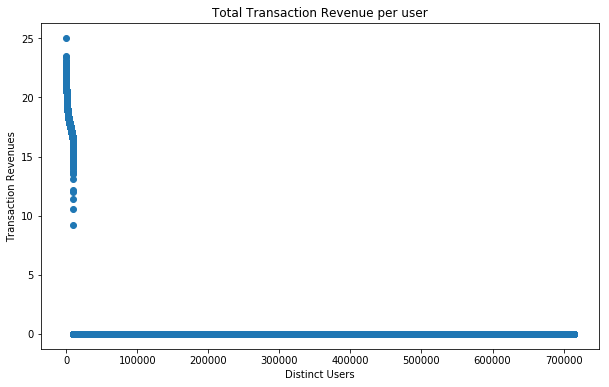

In [47]:
temp_df = df.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index().sort_values('totals.transactionRevenue', 
                                                                                                   ascending = False)
plt.subplots(figsize = (10,6))
plt.scatter(x = range(temp_df.shape[0]), y = np.log1p(temp_df["totals.transactionRevenue"]))
plt.xlabel('Distinct Users')
plt.ylabel('Transaction Revenues')
plt.title('Total Transaction Revenue per user')

The above plot confirms 80/20 rule. Only a small fraction of users generate maximum revenue while the majority generates very less or no revenue.

13. Plotting the count of page views,

Text(0.5,1,'Count of page views')

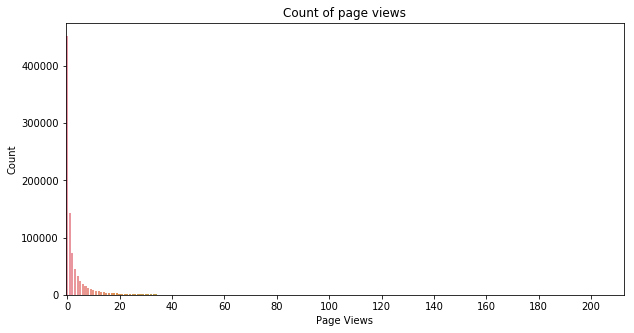

In [48]:
plt.subplots(figsize = (10,5))
sns.countplot(data = df, x = 'totals.pageviews')
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=20))
ax.set(xlabel = 'Page Views', ylabel = 'Count')
ax.set_title('Count of page views')

The above shows that maximum number of store page views have only been once or twice. The span of major fraction of page views range from 1 to 40, with 1-10 being the majority of times.

14. Again, plotting page views vs transaction revenue,

Text(0.5,1,'Page Views vs Transaction Revenue')

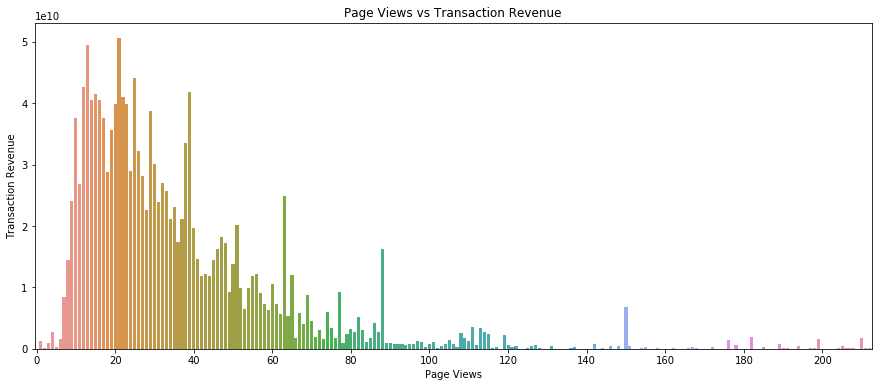

In [49]:
plt.subplots(figsize = (15,6))
temp_df = df.groupby(['totals.pageviews']).sum().reset_index()
sns.barplot(data = temp_df, x = 'totals.pageviews',y = 'totals.transactionRevenue')
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=20))
ax.set(xlabel = 'Page Views', ylabel = 'Transaction Revenue')
ax.set_title('Page Views vs Transaction Revenue')

The above shows that transaction revenues are highest for page views between 10 to 80.

15. Lastly plotting distribution of non-zero transaction revenues,

Text(0.5,1,'Distribution of log of non-zero transaction revenues')

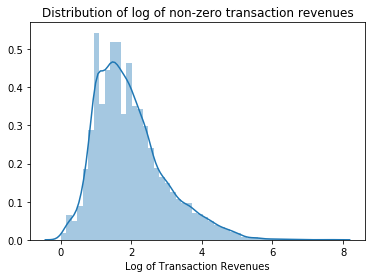

In [50]:
ax = sns.distplot( np.log1p(df[df['totals.transactionRevenue'] > 0]['totals.transactionRevenue'] / 10e+6) )
ax.set(xlabel = 'Log of Transaction Revenues')
ax.set_title('Distribution of log of non-zero transaction revenues')

16. Plotting count of traffic source, we observe that maximum traffic to the store has been directed from google, youtube or direct page hit.

Text(0.5,1,'Traffic Source Count')

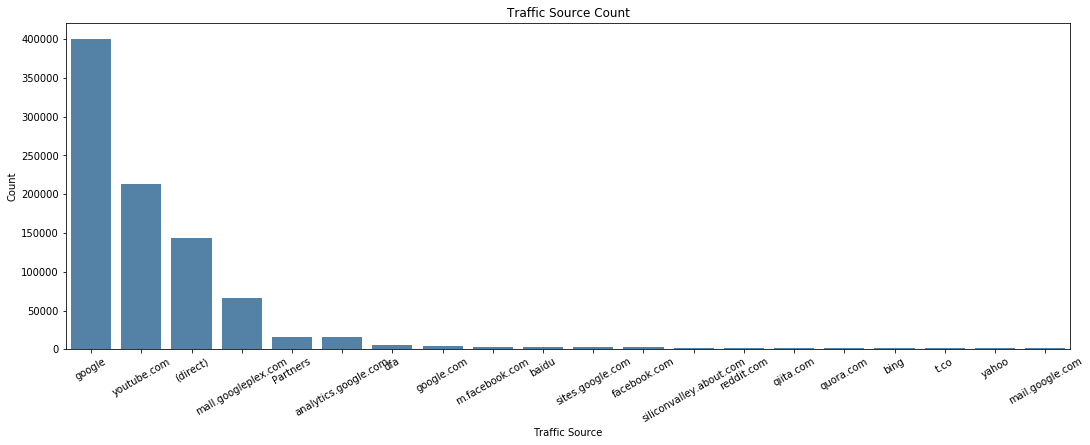

In [210]:
temp_df = df.groupby(['trafficSource.source']).count().reset_index().sort_values('totals.pageviews', 
                                                                                 ascending = False).head(20)
plt.subplots(figsize = (18,6))
ax = sns.barplot(data = temp_df, x = 'trafficSource.source', y = 'totals.pageviews', color = 'steelblue')
ax.set_xticklabels(plt.xticks()[1], rotation = 30)
ax.set(xlabel = 'Traffic Source', ylabel = 'Count')
ax.set_title('Traffic Source Count')

17. Plotting transaction revenue by traffic source, we observe that this time most revenue has been generated when traffic was directed from mail.googleplex.com, direct page hit and google.

Text(0.5,1,'Traffic Source vs Transaction Revenue')

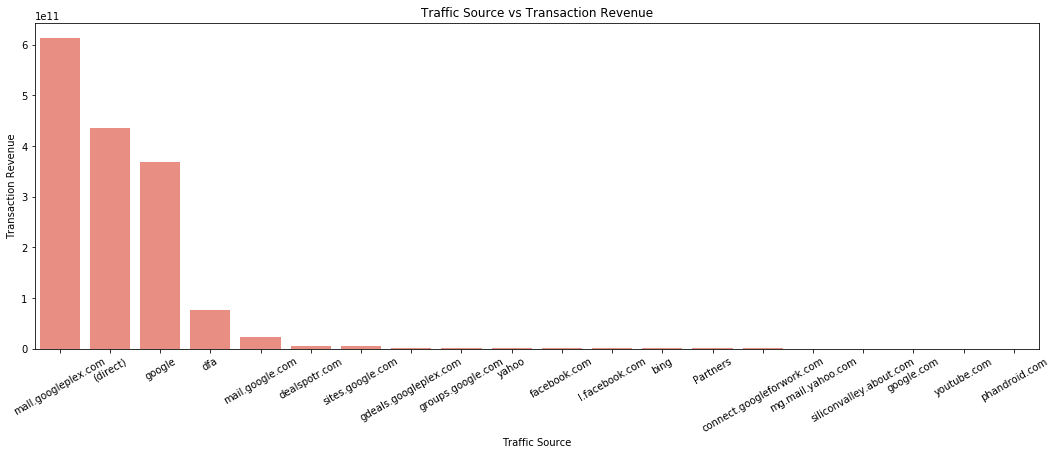

In [211]:
temp_df = df.groupby(['trafficSource.source']).sum().reset_index().sort_values('totals.transactionRevenue', 
                                                                                 ascending = False).head(20)
plt.subplots(figsize = (18,6))
ax = sns.barplot(data = temp_df, x = 'trafficSource.source', y = 'totals.transactionRevenue', color = 'salmon')
ax.set_xticklabels(plt.xticks()[1], rotation = 30)
ax.set(xlabel = 'Traffic Source', ylabel = 'Transaction Revenue')
ax.set_title('Traffic Source vs Transaction Revenue')

<hr>

### Task 3

1. Let's plot the count of visits by users on different continents.  

Text(0.5,1,'Number of visits by users on different continents')

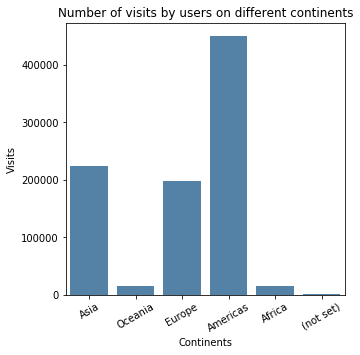

In [51]:
plt.subplots(figsize = (5,5))
ax = sns.countplot(data = df, x = 'geoNetwork.continent', color = 'steelblue')
ax.set_xticklabels(plt.xticks()[1], rotation = 30)
ax.set(xlabel = 'Continents', ylabel = 'Visits')
ax.set_title('Number of visits by users on different continents')

It can be observed that most of the user visits are from the Americas followed by Asia and Europe.

2. Plotting continents vs transaction revenue,

Text(0.5,1,'Continents vs Transaction Revenue')

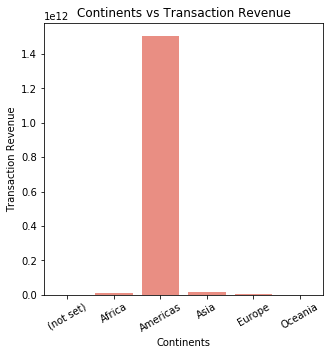

In [52]:
plt.subplots(figsize = (5,5))
ax = sns.barplot(data = df.groupby(['geoNetwork.continent']).sum().reset_index(), 
                 x = 'geoNetwork.continent', y = 'totals.transactionRevenue', color = 'salmon')
ax.set_xticklabels(plt.xticks()[1], rotation = 30)
ax.set(xlabel = 'Continents', ylabel = 'Transaction Revenue')
ax.set_title('Continents vs Transaction Revenue')

The observation here is that most of the transaction revenue comes from Americas. Even though Asia and Europe were next in line in terms of number of visits, they contribute almost nothing to total revenue in comparison with Americas.

3. Now, let's plot the count of visits by users on different subcontinents.

Text(0.5,1,'Number of visits by users on different sub continents')

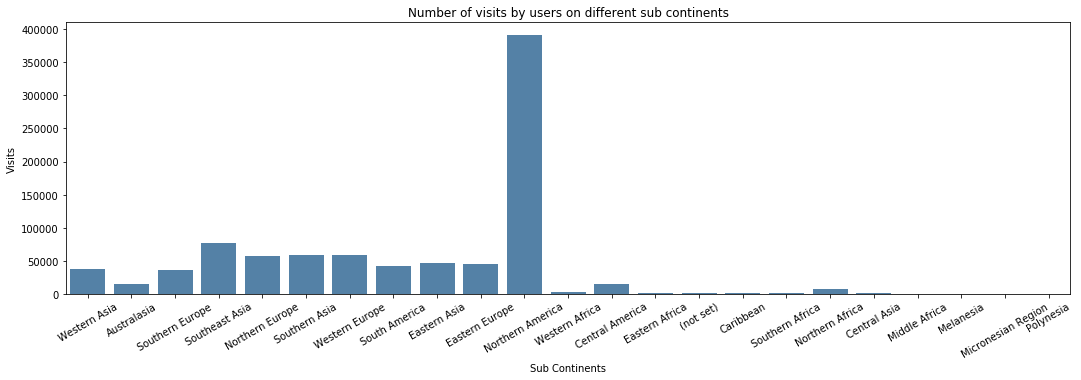

In [53]:
plt.subplots(figsize = (18,5))
ax = sns.countplot(data = df, x = 'geoNetwork.subContinent', color = 'steelblue')
ax.set_xticklabels(plt.xticks()[1], rotation = 30)
ax.set(xlabel = 'Sub Continents', ylabel = 'Visits')
ax.set_title('Number of visits by users on different sub continents')

It can be observed that most of the user visits are from North America followed by sub regions in Europe and Asia.

4. Plotting Sub continent vs transaction revenue,

Text(0.5,1,'Sub continents vs Transaction Revenue')

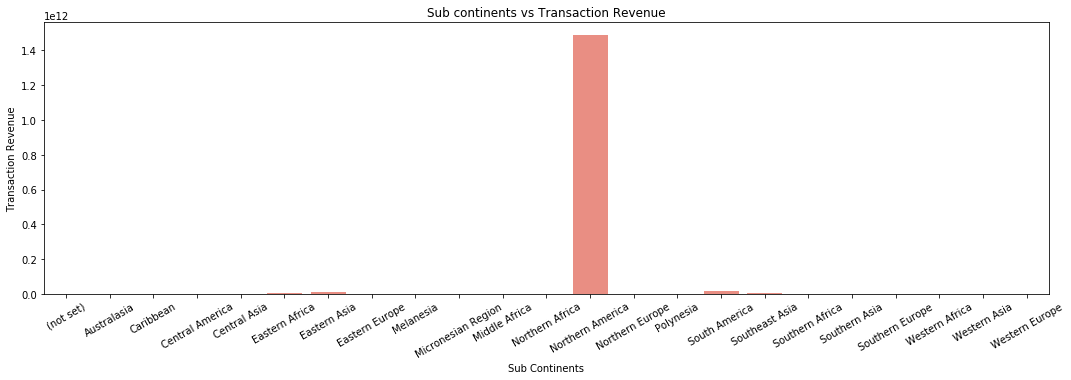

In [54]:
plt.subplots(figsize = (18,5))
ax = sns.barplot(data = df.groupby(['geoNetwork.subContinent']).sum().reset_index(), 
            x = 'geoNetwork.subContinent', y = 'totals.transactionRevenue', color = 'salmon')
ax.set_xticklabels(plt.xticks()[1], rotation = 30)
ax.set(xlabel = 'Sub Continents', ylabel = 'Transaction Revenue')
ax.set_title('Sub continents vs Transaction Revenue')

Most of the revenue comes from North America.

5. We can also plot number of visits by country on a geographical plot

In [55]:
init_notebook_mode(connected=True)

In [56]:
temp_df = df.groupby(['geoNetwork.country']).count().reset_index()

In [57]:
data = dict(type = 'choropleth', 
           locations = temp_df['geoNetwork.country'],
           locationmode = 'country names',
           z = temp_df['visitId'], 
           text = temp_df['geoNetwork.country'],
           colorbar = {'title':'Number of visits'})
layout = dict(title = 'Number of visits by Country', 
             geo = dict(showframe = False))
choromap3 = go.Figure(data = [data], layout=layout)
iplot(choromap3)

<hr>

### Task 4

1. Print the available columns

In [58]:
df.dtypes

channelGrouping                       object
date                          datetime64[ns]
fullVisitorId                         object
sessionId                             object
visitId                               object
visitNumber                            int64
visitStartTime                datetime64[ns]
visitStartTime.week                    int64
visitStartTime.day                     int64
visitStartTime.hour                    int64
date.year                              int64
date.month                             int64
device.browser                        object
device.deviceCategory                 object
device.isMobile                         bool
device.operatingSystem                object
geoNetwork.city                       object
geoNetwork.continent                  object
geoNetwork.country                    object
geoNetwork.metro                      object
geoNetwork.networkDomain              object
geoNetwork.region                     object
geoNetwork

2. We'll first create a column 'has_bought' with value as 1 if something has been bought (transaction has occured), 0 otherwise.

In [59]:
df['has_bought'] = df.apply(lambda row: 0 if row['totals.transactionRevenue'] == 0 else 1, axis = 1)

We'll also create copies of df and test before proceeding.

In [60]:
train = df.copy()
test_copy = test.copy()

3. Maintaining a list of categorical columns,

In [61]:
cat_cols = ["channelGrouping", "device.browser", 
            "device.deviceCategory", "device.operatingSystem", 
            "geoNetwork.city", "geoNetwork.continent", 
            "geoNetwork.country", "geoNetwork.metro",
            "geoNetwork.networkDomain", "geoNetwork.region", 
            "geoNetwork.subContinent", "trafficSource.campaign",
            "trafficSource.keyword", "trafficSource.medium", 
            "trafficSource.referralPath", "trafficSource.source",
            'trafficSource.isTrueDirect']

4. Let's have a look at the unique categories for each cat_cols

In [62]:
train[cat_cols].nunique()

channelGrouping                   8
device.browser                   54
device.deviceCategory             3
device.operatingSystem           20
geoNetwork.city                 649
geoNetwork.continent              6
geoNetwork.country              222
geoNetwork.metro                 94
geoNetwork.networkDomain      28064
geoNetwork.region               376
geoNetwork.subContinent          23
trafficSource.campaign           10
trafficSource.keyword          3659
trafficSource.medium              7
trafficSource.referralPath     1476
trafficSource.source            380
trafficSource.isTrueDirect        2
dtype: int64

5. We'll now encode the string columns with value between 0 and n_classes-1.

In [71]:
for col in cat_cols:
    print(col)
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train[col].values.astype('U')) + list(test_copy[col].values.astype('U')))
    train[col] = lbl.transform(list(train[col].values.astype('U')))
    test_copy[col] = lbl.transform(list(test_copy[col].values.astype('U')))

channelGrouping
device.browser
device.deviceCategory
device.operatingSystem
geoNetwork.city
geoNetwork.continent
geoNetwork.country
geoNetwork.metro
geoNetwork.networkDomain
geoNetwork.region
geoNetwork.subContinent
trafficSource.campaign
trafficSource.keyword
trafficSource.medium
trafficSource.referralPath
trafficSource.source
trafficSource.isTrueDirect


6. Now, let's create an array of feature names to be used for predicting

In [72]:
pred_features = [
    'channelGrouping',
    'device.browser',
    'device.deviceCategory',
    'device.operatingSystem',
    'geoNetwork.continent',
    'geoNetwork.subContinent',
    'totals.hits',
    'totals.pageviews']

7. We'll create a Logistic Regression model and use the above features as training data and 'has_bought' as the predicting column. Also, we'll print the support and ranking coefficients.

In [73]:
logreg = LogisticRegression()
rfe = RFE(logreg, 20)
rfe = rfe.fit(train[pred_features], train['has_bought'].values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True  True  True  True  True]
[1 1 1 1 1 1 1 1]


8. Let's look at the summary of the logit model.

In [74]:
import statsmodels.api as sm
logit_model=sm.Logit(train['has_bought'], train[pred_features])
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.040514
         Iterations 12
                             Results: Logit
Model:                 Logit              Pseudo R-squared:   0.406     
Dependent Variable:    has_bought         AIC:                73229.9157
Date:                  2018-10-22 13:58   BIC:                73323.6284
No. Observations:      903553             Log-Likelihood:     -36607.   
Df Model:              7                  LL-Null:            -61678.   
Df Residuals:          903545             LLR p-value:        0.0000    
Converged:             1.0000             Scale:              1.0000    
No. Iterations:        12.0000                                          
------------------------------------------------------------------------
                         Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------------
channelGrouping         -0.0010   0.0068  -0.1436 

9. Now, let's predict the likelihood of a user buying a product from the store

In [75]:
logreg = LogisticRegression()
logreg.fit(train[pred_features], train['has_bought'])
y_pred = logreg.predict(train[pred_features])

In [76]:
proby= logreg.predict_proba(train[pred_features])

In [197]:
train_temp = train.copy()

In [198]:
train_temp['buying_prob'] = proby[:,1]

In [201]:
df_mean = train_temp.groupby(['fullVisitorId']).mean().reset_index()

10. Printing the top ten most likely users

In [205]:
df_mean.sort_values('buying_prob',ascending=False).head(10)['fullVisitorId']

279740    3924372865099736100
394267    5526675926038480325
638751    8942866004645538967
394637    5531986444834608429
120920    1701094142213220059
19424     0270832659599010298
550732    7713012430069756739
57434     0807236855616914537
505163    7077052090651787985
253089     354963997732144685
Name: fullVisitorId, dtype: object

<hr>

### Task 5

For the external dataset, I visited the Google Analytics website and created a demo account. From there, I visited their Google Merchandise Store dashboard and downloaded the following data set from the User Explorer.

https://drive.google.com/drive/folders/1zmxxGR0Xqai8JiMajGSn3dQ65C89uLZj?usp=sharing

The above data set contains just a sample number of rows of the entire available data set. This data set contains the visit Id as well as bounce rate, session duration, revenue, number of transactions and goal conversion rate for the time period same as the Kaggle training data. This dataset can be joined with the training data and the additional features can be used for prediction models.

<hr>

### Task 6

1. We'll define the numeric columns and other categorical prediction features for the prediction model.

In [179]:
num_cols = ['totals.hits', 'totals.pageviews', 'visitStartTime.week']
pred_features = ["channelGrouping", "device.browser", 
            "device.deviceCategory", "device.operatingSystem", 
            "geoNetwork.city", "geoNetwork.continent", 
            "geoNetwork.country", "geoNetwork.metro",
            "geoNetwork.region", "geoNetwork.subContinent", "trafficSource.campaign",
            "trafficSource.keyword", "trafficSource.medium", 
            "trafficSource.referralPath", "trafficSource.source",
            'trafficSource.isTrueDirect']

2. Convert test data columns wherever necessary.

In [80]:
test_copy['totals.hits'] = test_copy['totals.hits'].apply(pd.to_numeric)
test_copy['totals.pageviews'] = test_copy['totals.pageviews'].apply(pd.to_numeric)
test_copy['totals.bounces'] = test_copy['totals.bounces'].apply(pd.to_numeric)

3. We'll perform natural log of transactionRevenue and also get the train_X and test_X.

In [180]:
train_X = train[cat_cols + num_cols]
test_X = test_copy[cat_cols + num_cols]
train_y = np.log1p(train["totals.transactionRevenue"].values)

In [181]:
params = {'learning_rate': 0.03, 
         'objective': 'regression', 
         'metric': 'rmse', 
         'num_leaves': 31,
         'bagging_fraction': 0.7, 
         'feature_fraction': 0.5,
         'bagging_frequency': 5,
         'min_child_samples': 100,
         'bagging_seed': 2019,
         'subsample': .9,
         'colsample_bytree': .9
        }

4. We'll perform a simple Light Gradient Boosted Modelling training method for the prediction.

In [182]:
lgtrain = lgbm.Dataset(train_X, label=train_y)

In [183]:
model = lgbm.train(params, lgtrain)

In [184]:
pred_test = model.predict(test_copy[pred_features + num_cols])

5. Saving to a submission file.

In [185]:
sub_df = pd.DataFrame({"fullVisitorId":test["fullVisitorId"].values})
pred_test[pred_test<0] = 0
sub_df["PredictedLogRevenue"] = np.expm1(pred_test)
sub_df = sub_df.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
sub_df.columns = ["fullVisitorId", "PredictedLogRevenue"]
sub_df["PredictedLogRevenue"] = np.log1p(sub_df["PredictedLogRevenue"])
sub_df.to_csv("submission.csv", index=False)

<hr>

### Task 7

1. Let's create a copy of training data

In [95]:
perm_df = train.copy()

2. We'll sample some rows from the data since permutation test will take a lot of time to run.

In [96]:
sample_df = perm_df.sample(250000)

3. Let's run a simple linear regression prediction for natural log of transaction revenue so get the original rmse value.

In [97]:
lg = linear_model.LinearRegression()

In [103]:
X_train, X_test, Y_train, Y_test = train_test_split(sample_df[pred_features + num_cols], 
                                                    np.log1p(sample_df['totals.transactionRevenue']), 
                                                    test_size=0.1, random_state=123) 

In [104]:
lg.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [105]:
pred_test = lg.predict(X_test)

In [106]:
lrmse = np.sqrt(mean_squared_error(Y_test, pred_test))
lrmse

1.8139506973225705

4. Now, for each column, we'll randomly permute its respective values and generate rmse scores 1000 times.

In [111]:
lrmse_dict = {}
for c in pred_features + num_cols:
    sample_copy = sample_df.copy()
    lrmse_dict[c] = list()
    for itr in range(1000):
        sample_copy[c] = np.random.permutation(sample_copy[c])
        X_train, X_test, Y_train, Y_test = train_test_split(sample_copy[pred_features + num_cols], 
                                                    np.log1p(sample_copy['totals.transactionRevenue']), 
                                                    test_size=0.1, random_state=123) 
        lg.fit(X_train, Y_train)
        pred_test = lg.predict(X_test)
        lrmse_dict[c].append(np.sqrt(mean_squared_error(Y_test, pred_test)))

5. Print all the rmse scores

In [113]:
lrmse_dict

{'channelGrouping': [1.8144926773980707,
  1.8144911489267221,
  1.8144893449874309,
  1.814489210380145,
  1.814545611086617,
  1.8144545041798548,
  1.8144914496291662,
  1.8145765675051488,
  1.814489034983246,
  1.8144444743081618,
  1.8145386618565755,
  1.814513919069955,
  1.8144164384593617,
  1.8145137830868772,
  1.8144697606772504,
  1.8145087132283675,
  1.8144864801460392,
  1.814489595586593,
  1.8144884950028897,
  1.814486832579434,
  1.8144721694378916,
  1.8144779004339118,
  1.814583816762463,
  1.81448714674168,
  1.8144827262208734,
  1.8145099387749755,
  1.8144909615387756,
  1.8144534397918342,
  1.8144828451657196,
  1.814525562313592,
  1.814488417689456,
  1.8145020278243273,
  1.81445517350255,
  1.8144838798958716,
  1.8144971009720716,
  1.814494995161113,
  1.814492518269102,
  1.8144883709919624,
  1.8144918254830749,
  1.8144821386095782,
  1.8144879245824928,
  1.8144893398676651,
  1.8144804512433366,
  1.8144855456215006,
  1.8144965360107583,
  1.81

6. Let's create permutation distribution plots for all the considered columns.

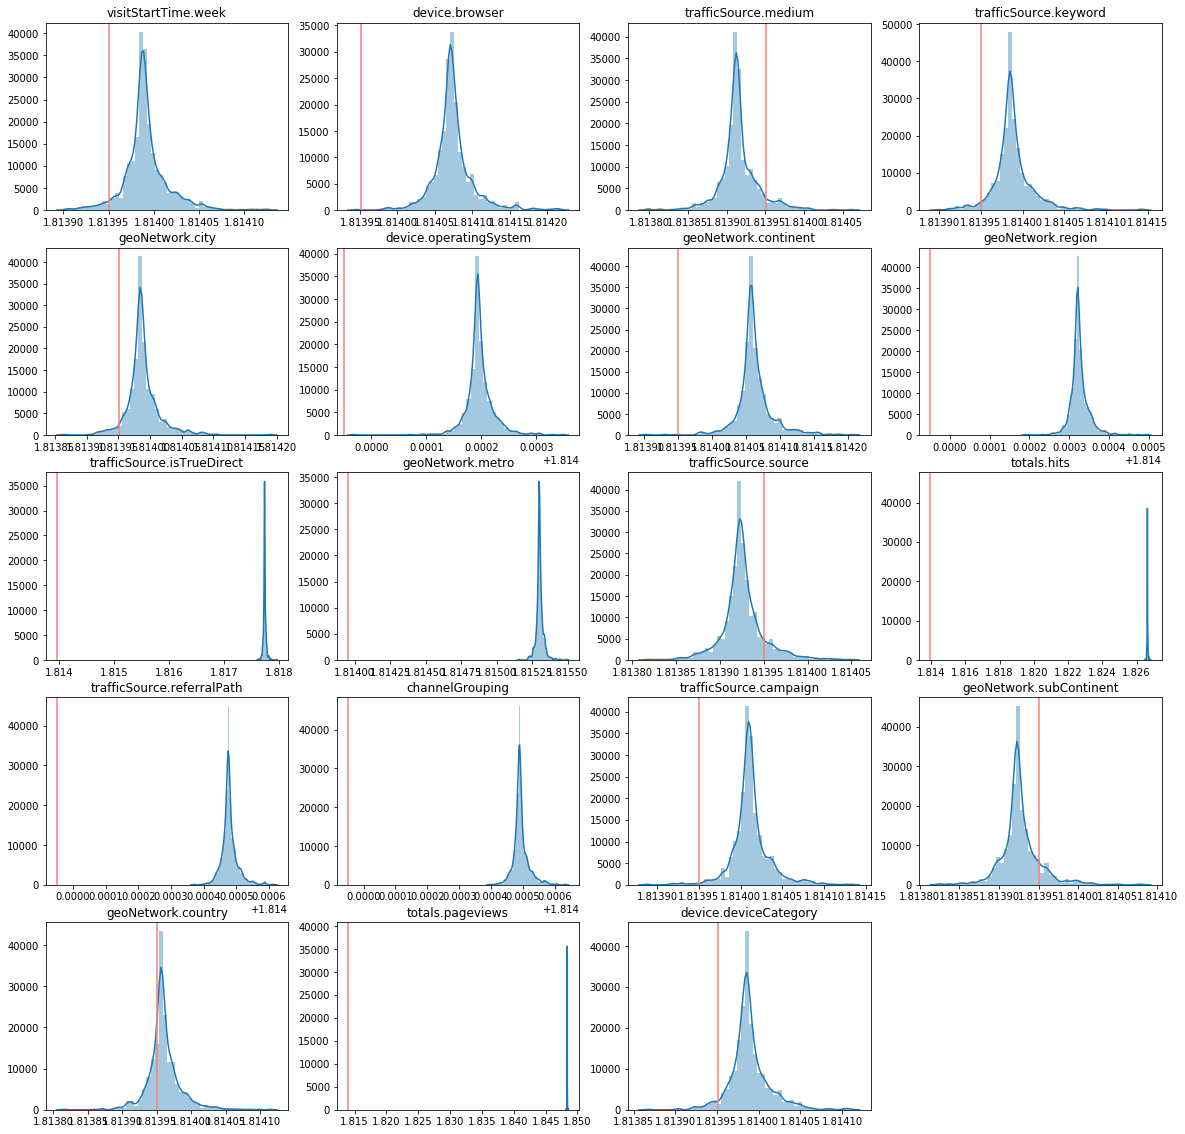

In [138]:
plt.subplots(figsize = (20, 20))
columns = list(lrmse_dict.keys())
for i in range(len(columns)):
    plt.subplot(5, 4, i+1)
    ax = sns.distplot(lrmse_dict[columns[i]])
    ax.set_title(columns[i])
    ax.axvline(lrmse, color = 'salmon')

For the above figures, salmon colored line shows the original rmse score. Since permuted rmse scores should be much greater than original rmse score, we'll calculate the pvalues by considering all permuted points falling before the original rmse score.

In [145]:
pvalue_dict = dict()
for c in columns:
    pvalue = 0
    lrmse_array = lrmse_dict[c]
    total_values = len(lrmse_array)
    for val in lrmse_array:
        if val < lrmse:
            pvalue += 1
    pvalue = float(pvalue) / total_values
    pvalue_dict[c] = pvalue

In [146]:
pvalue_dict

{'channelGrouping': 0.0,
 'device.browser': 0.001,
 'device.deviceCategory': 0.043,
 'device.operatingSystem': 0.0,
 'geoNetwork.city': 0.043,
 'geoNetwork.continent': 0.003,
 'geoNetwork.country': 0.266,
 'geoNetwork.metro': 0.0,
 'geoNetwork.region': 0.0,
 'geoNetwork.subContinent': 0.876,
 'totals.hits': 0.0,
 'totals.pageviews': 0.0,
 'trafficSource.campaign': 0.011,
 'trafficSource.isTrueDirect': 0.0,
 'trafficSource.keyword': 0.038,
 'trafficSource.medium': 0.927,
 'trafficSource.referralPath': 0.0,
 'trafficSource.source': 0.883,
 'visitStartTime.week': 0.038}

The above pvalues depict that values of columns: Channel Grouping, Device Browser, Device Category, Operating System, Continent, City Region, Metro, Page Views did not occur by chance. Whereas, the columns trafficSource.source, trafficSource.medium, geoNetwork.country, geoNetwork.subcontinent have very bad pvalues.